# Economie du stockage

In [70]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
%matplotlib inline 
plt.style.use('ggplot')

In [71]:
prices = pd.read_csv('Day-ahead_Prices_FR_2020.csv',sep=";",encoding='utf-8',decimal=',')
prices = prices.rename(columns={"MTU (CET)":'Time','Day-ahead Price [EUR/MWh]':'Price'})
prices['Price'] = prices['Price'].str.replace(',','.')

In [72]:
df = prices.iloc[:744].copy() #31*24 = 744
# Preprocessing pour avoir un df clean
df['Day'] = [i//24 for i in range(len(df))]
df['BeginTime']  = pd.to_datetime([t.split('-')[0] for t in df['Time']])
df = df[['Day','BeginTime','Price']]
df['Price'] = pd.to_numeric(df['Price'])

In [73]:
df.head(1)

,Day,BeginTime,Price
0,0,2020-01-01,41.88


In [74]:
df.tail(2)

,Day,BeginTime,Price
742,30,2020-01-31 22:00:00,28.74
743,30,2020-01-31 23:00:00,24.12


In [75]:
df['BeginTime']

0     2020-01-01 00:00:00
1     2020-01-01 01:00:00
2     2020-01-01 02:00:00
3     2020-01-01 03:00:00
4     2020-01-01 04:00:00
              ...        
739   2020-01-31 19:00:00
740   2020-01-31 20:00:00
741   2020-01-31 21:00:00
742   2020-01-31 22:00:00
743   2020-01-31 23:00:00
Name: BeginTime, Length: 744, dtype: datetime64[ns]

No handles with labels found to put in legend.


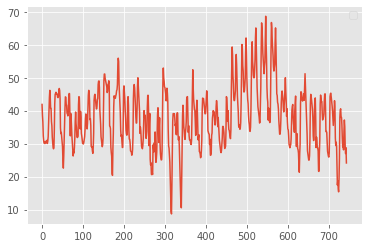

In [76]:
plt.plot(df['Price'])
plt.legend()
plt.show()

# Charge & Décharge

Alternance de cycle de charge et de décharge : 
(0,1,0,1)
0 = charge
1 = décharge 

> Connaissant les prix fixés à l'avance nous allons donc charger notre batterie sur le réseau quand le prix est le plus faible et le vendre ensuite quand le prix est le plus elevé

### Il faut trouver pour chaque les deux prix qui sont les plus compétitifs. Le prix le plus faible avant le prix le plus elevé.

In [242]:
def plot_min_max(df,i):
    plt.figure(figsize=(7,7))
    df[df.Day==i]['Price'].reset_index(drop=True).plot()
    id_min,id_max,min_price,max_price = find_min_max(df,i)
    plt.xlabel('Heures')
    plt.ylim(min_price-7,max_price+8)
    plt.xlim(-1,25)
    # Minimum
    plt.arrow(id_min,min_price-5,0,4,head_width =0.5,width=0.25,ec="green")
    plt.text(id_min+0.5,min_price-3,f'Minimum\n{id_min} h - {min_price}€')
    # Maximum
    plt.arrow(id_max,max_price+5,0,-4,head_width =0.5,width=0.25,ec="blue")
    plt.text(id_max+0.5,max_price+3,f'Maximum\n{id_max} h - {max_price}€')
    plt.legend(loc='upper left')
    plt.title(f'{i+1}/01 - {round(max_price-min_price,2)} € bénéfices')
    plt.show()

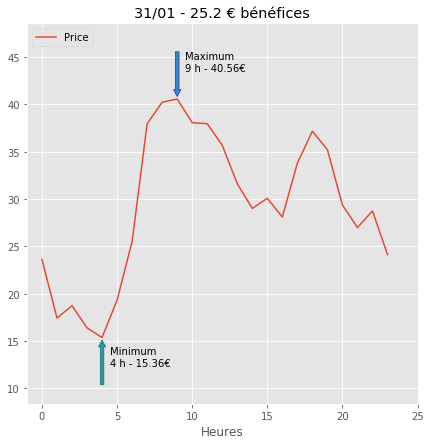

In [245]:
plot_min_max(df,30)

## Créer une matrice : 
colonnes : jour & lignes : min & max 
rectangle, avec un indice pour vérifier que le min précède le top

In [151]:
find_min_max(day0)

(7, 19, 30.0, 46.16)

In [125]:
def find_min_max(df,i=0):
    """Permet de trouver le min et le max de la fonction prix en garantissant que le minimum précède le maximum"""
    day = df[df.Day==i].reset_index(drop=True)
    id_min=1
    id_max =0
    while id_min > id_max:
        id_min = day['Price'].idxmin()
        id_max = day['Price'].idxmax()
        max_price = max(day.Price)
        min_price = min(day.Price)
        # Si le id_min apparait après le max, on ne va pas le considérer
        # Le maximum de prix ne peut pas non plus être au début du df 
        if id_max ==0:
            day = day.drop(id_max)
        else:
            day = day.drop(id_min)
    return(id_min,id_max,min_price,max_price)

In [133]:
df[df.Day==1].index

Int64Index([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
            41, 42, 43, 44, 45, 46, 47],
           dtype='int64')

In [139]:
def create_price_matrix(df):
    mat = np.zeros((max(df.Day)+1,2,2))
    for i in range(max(df.Day)+1):
        # Extraire les prix de la journée max 
        id_min,id_max,min_price,max_price = find_min_max(df,i=i)
        mat[i][0][0] = min_price
        mat[i][1][0] = max_price
        mat[i][0][1] = id_min+min(df[df.Day==i].index)
        mat[i][1][1] = id_max+min(df[df.Day==i].index)
    return(mat)

In [145]:
mat[0][1][0]

46.16

### Calculer le profit 

In [146]:
def calc_profit(df,mat):
    daily_profit = []
    for i in range(max(df.Day)+1):
        profit = mat[i][1][0]-mat[i][0][0]
        daily_profit.append(profit)
    return(daily_profit)
    

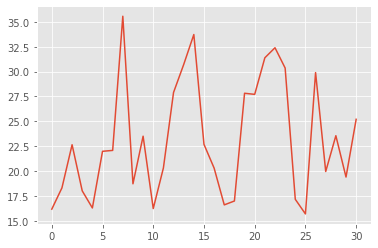

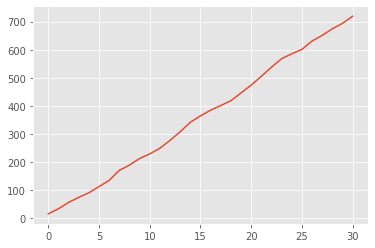

In [150]:
plt.plot(calc_profit(df,mat))
plt.show()
plt.plot(np.cumsum(np.array(calc_profit(df,mat))))

In [60]:
etat = [i%2 for i in range(len(df))]

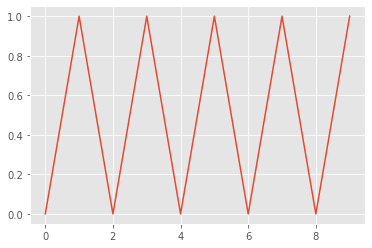

In [66]:
plt.plot(range(10),etat[:10])

,MTU (CET),Day-ahead Price [EUR/MWh],day
0,01.01.2020 00:00 - 01.01.2020 01:00,41.88,1
1,01.01.2020 01:00 - 01.01.2020 02:00,38.6,1
2,01.01.2020 02:00 - 01.01.2020 03:00,36.55,1
3,01.01.2020 03:00 - 01.01.2020 04:00,32.32,1
4,01.01.2020 04:00 - 01.01.2020 05:00,30.85,1
5,01.01.2020 05:00 - 01.01.2020 06:00,30.14,1
6,01.01.2020 06:00 - 01.01.2020 07:00,30.17,1
7,01.01.2020 07:00 - 01.01.2020 08:00,30,1
8,01.01.2020 08:00 - 01.01.2020 09:00,30.65,1
9,01.01.2020 09:00 - 01.01.2020 10:00,30.65,1


In [70]:
df['Day-ahead Price [EUR/MWh]'].tolist()

TypeError: can't multiply sequence by non-int of type 'list'

In [73]:
ventes = [df['Day-ahead Price [EUR/MWh]'][i]*etat[i] for i in range(len(df))]

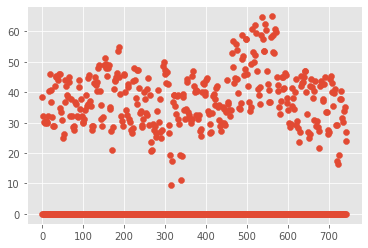

In [78]:
plt.scatter(range(len(ventes)),ventes)

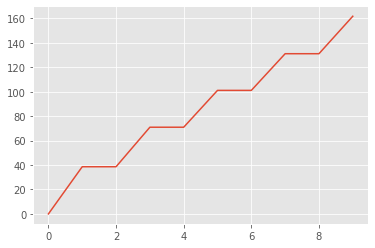

In [83]:
plt.plot(np.cumsum(ventes)[:10])